# Neural Networks Project
Neural Networks course at Sapienza University of Rome
## DreamDiffusion: Generating High-Quality Images from Brain EEG Signals

*   Paolo Caruso 1843152 
*   Cristian Fioravanti 1861593

The objective of this notebook is to reproduce and reimplement the work carried out by the authors of the "<b>DreamDiffusion</b>" (https://arxiv.org/pdf/2306.16934.pdf) paper, exploring the key steps of the proposed algorithm and providing a practical and accessible version for the generation of images starting from EEG signals.

## Paper contribution
The authors of the papers presents a method for generating high-quality images directly from brain electroencephalogram (EEG) signals, without the need to translate thoughts into text.
DreamDiffusion leverages pretrained text-to-image Stable Diffusion model and employs temporal masked signal modeling to pre-train the EEG encoder for effective and robust EEG representations. Additionally, the method further leverages the CLIP image encoder to provide extra supervision to better align EEG, text, and image embeddings with limited EEG-image pairs.
The authors' intuition is to define a Masked Autoencoder which randomly mask a proportion of tokens and then reconstruct those masked ones in the time domain. In this way, the pre-trained encoder learns a deep understanding of EEG data across different people and various brain activities. Stable Diffusion itself uses CLIP’s text encoder to generate text embeddings, which are quite different from the masked pre-trained EEG embeddings in the previous stage. We leverage CLIP’s image encoder to extract rich image embeddings that align well with CLIP text embeddings. Those CLIP image embeddings are then used to further optimize EEG embedding representations. Therefore, the refined EEG feature embeddings can be well aligned with the CLIP image and text embeddings, and are more suitable for SD image generation, which in turn improves the quality of generated images.

The structure of the proposed method is presented here: ![Schema](docs/schema.png)

So the method is composed by three different sections:
1. Masked signal pre-training for effective and robust EEG representations: in which  masked signal are leveraged modeling with lots of noisy EEG data to train an EEG encoder to extract contextual knowledge.
2. Fine-tuning with limited EEG-image pairs with pre-trained Stable Diffusion: in which the resulting EEG encoder is then employed to provide conditional features for Stable Diffusion via the cross-attention mechanism.
3. Aligning the EEG, text, and image spaces using CLIP encoders: in which the EEG, text, and image embedding spaces are aligned by reducing the distance between EEG embeddings and CLIP image embeddings during fine-tuning.

## Our implematation

### Datasets
* A large amounts of [EEG data](https://studentiunict-my.sharepoint.com/personal/concetto_spampinato_unict_it/_layouts/15/onedrive.aspx?id=%2Fpersonal%2Fconcetto%5Fspampinato%5Funict%5Fit%2FDocuments%2Fsito%5FPeRCeiVe%2Fdatasets%2Feeg%5Fcvpr%5F2017&ga=1) used to pre-training in order to achieve an efficient Masked AutoEncoder.
* A set of [EEG-image pairs](https://studentiunict-my.sharepoint.com/personal/concetto_spampinato_unict_it/_layouts/15/onedrive.aspx?id=%2Fpersonal%2Fconcetto%5Fspampinato%5Funict%5Fit%2FDocuments%2Fsito%5FPeRCeiVe%2Fdatasets%2Feeg%5Fcvpr%5F2017&ga=1) used to accurately align the EEG features with existing text embedding. These EEG are obtained from some subjects while they were shown 2000 images belonging to 40 different categories of objects from the ImageNet
dataset.
* A subset of [ImageNet](https://drive.google.com/file/d/1y7I9bG1zKYqBM94odcox_eQjnP9HGo9-/view?usp=drive_link) containing the images showed to subsets.

All these datasets are downloaded, prepared and splitted using specific dataloader.

### Masked signal pre-training for effective and robust EEG representations
In order to implement this section we define a MAE (Masked AutoEncoder) which is composed by:
* Encoder: to transform the input EEG data in a latent representation. the input is divided in unidimensional patches using a PatchEmbed1D. This is composed by a 1D convolution layer. The patches are elaborated by a series Transformers Blocks: each of which applies multi-head self-attention followed by a feedforward neural network. During encoding, a random mask is applied in order to mask a portion of the input information. This process helps the model learn representations that are robust and invariant to random variations in the input data.
* Decoder: The decoder takes the latent representation generated by the encoder and tries to reconstruct the original input. It uses a series of encoder-like Transformer blocks to decode the latent representation. During decoding, mask tokens are added to handle the reconstruction of patches that were masked during encoding.
* Loss Function: The loss function is a form of Mean Squared Error (MSE) calculated between the original EEG signal and the reconstructed EEG signal. However, the loss is only calculated for patches that were masked during encoding, to encourage the model to focus on those patches during reconstruction.

Here the code of the definition of the MAE. 

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
import utils as ut
from timm.models.vision_transformer import Block

class PatchEmbed1D(nn.Module):
    def __init__(self, time_len=224, patch_size=1, in_chans=128, embed_dim=256):
        super().__init__()
        num_patches = time_len // patch_size  # 224
        self.patch_shape = patch_size
        self.time_len = time_len
        self.patch_size = patch_size
        self.num_patches = num_patches

        self.proj = nn.Conv1d(
            in_chans, embed_dim, kernel_size=patch_size, stride=patch_size
        )

    def forward(self, x, **kwargs):

        x = (
            # patch projected in the dimension of the embedding's dimention (embed_dim)
            self.proj(x).transpose(1, 2).contiguous() #from torch.Size([1, 1024, 128]) torch.Size([1, 128, 1024])
        )  # put embed_dim at the last dimension

        return x
    
class MaskedAutoEncoderEEG(nn.Module):
    def __init__(
        self,
        time_len=512,
        patch_size=4,
        embed_dim=1024,
        in_chans=128,
        depth=24,
        num_heads=16,
        decoder_embed_dim=512,
        decoder_depth=8,
        decoder_num_heads=16,
        mlp_ratio=1.0,
        norm_layer=nn.LayerNorm,
        focus_range=None,
        focus_rate=None,
        img_recon_weight=1.0,
    ):
        super().__init__()

        # --------------------------------------------------------------------------
        # MAE encoder specifics
        self.patch_embed = PatchEmbed1D(
            time_len, patch_size, in_chans, embed_dim)

        num_patches = int(time_len / patch_size)

        self.num_patches = num_patches
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))  # torch.Size([1, 1, 1024])
        self.pos_embed = nn.Parameter(
            torch.zeros(1, num_patches + 1, embed_dim), requires_grad=False #torch.Size([1, 129, 1024])
        )  # fixed sin-cos embedding

        self.blocks = nn.ModuleList(
            [
                 Block(embed_dim, num_heads, mlp_ratio, qkv_bias=True, norm_layer=norm_layer)
                for i in range(depth)
            ]
        )
        self.norm = norm_layer(embed_dim)
        # --------------------------------------------------------------------------

        # --------------------------------------------------------------------------
        # MAE decoder specifics
        self.mask_token = nn.Parameter(torch.zeros(1, 1, decoder_embed_dim))

    
        self.decoder_embed = nn.Linear(embed_dim, decoder_embed_dim, bias=True)
    
        self.decoder_pos_embed = nn.Parameter(
            torch.zeros(1, num_patches + 1, decoder_embed_dim), requires_grad=False
        )  # fixed sin-cos embedding

        self.decoder_blocks = nn.ModuleList(
            [
               Block(decoder_embed_dim, decoder_num_heads, mlp_ratio, qkv_bias=True, norm_layer=norm_layer)
               for i in range(decoder_depth)
            ]
        )

        self.decoder_norm = norm_layer(decoder_embed_dim)
        self.decoder_pred = nn.Linear(
            decoder_embed_dim, in_chans * patch_size, bias=True
        )  # encoder to decoder

        self.patch_size = patch_size
        self.embed_dim = embed_dim
        self.focus_range = focus_range
        self.focus_rate = focus_rate
        self.img_recon_weight = img_recon_weight

        self.initialize_weights()

    def initialize_weights(self):
        # initialization
        pos_embed = ut.get_1d_sincos_pos_embed(
            self.pos_embed.shape[-1], self.num_patches, cls_token=True
        )
        decoder_pos_embed = ut.get_1d_sincos_pos_embed(
            self.decoder_pos_embed.shape[-1], self.num_patches, cls_token=True
        )
        self.pos_embed.data.copy_(
            torch.from_numpy(pos_embed).float().unsqueeze(0)
        )  # trasforma gli embedding in tensor

        self.decoder_pos_embed.data.copy_(
            torch.from_numpy(decoder_pos_embed).float().unsqueeze(0)
        )  # trasforma gli embedding in tensor

        # initialize patch_embed like nn.Linear (instead of nn.Conv2d)
        w = self.patch_embed.proj.weight.data
        torch.nn.init.xavier_uniform_(w.view([w.shape[0], -1]))

        # timm's trunc_normal_(std=.02) is effectively normal_(std=0.02) as cutoff is too big (2.)
        torch.nn.init.normal_(self.cls_token, std=0.02)
        torch.nn.init.normal_(self.mask_token, std=0.02)

        # initialize nn.Linear and nn.LayerNorm
        self.apply(
            self._init_weights
        )  # _init_weights viene applicato per inizializzare i pesi e bias per i livelli lineari e la normalizzazione del livello all'interno del model

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            # we use xavier_uniform following official JAX ViT:
            torch.nn.init.xavier_uniform_(m.weight)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
        elif isinstance(m, nn.Conv1d):
            torch.nn.init.normal_(m.weight, std=0.02)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)

    # Prende un tensore di immagini e lo converte in un formato di patch
    def patchify(self, imgs):
        """
        imgs: (N, 1, num_voxels)
        imgs: [N, chan, T]
        x: (N, L, patch_size)
        x: [N, chan * 4, T/4]
        """
        p = self.patch_embed.patch_size
        assert imgs.ndim == 3 and imgs.shape[1] % p == 0

        # h = imgs.shape[2] // p
        x = imgs.reshape(shape=(imgs.shape[0], imgs.shape[1] // p, -1))
        return x

    # prende un tensore di patch e lo converte in un formato di immagine
    def unpatchify(self, x):
        """
        x: (N, L, patch_size)
        imgs: (N, 1, num_voxels)
        """
        p = self.patch_embed.patch_size
        h = x.shape[1]

        imgs = x.reshape(shape=(x.shape[0], -1, x.shape[2] // p))
        return imgs.transpose(1, 2)

    def random_masking(self, x, mask_ratio):
        """
        Perform per-sample random masking by per-sample shuffling.
        Per-sample shuffling is done by argsort random noise.
        x: [N, L, D], sequence
        """
        N, L, D = x.shape  # batch, length, dim
        len_keep = int(L * (1 - mask_ratio))

        if self.focus_range is not None:
            len_mask = L - len_keep
            weights = [1 - self.focus_rate] * L
            weights[
                self.focus_range[0]
                // self.patch_size: self.focus_range[1]
                // self.patch_size
            ] = [self.focus_rate] * (
                self.focus_range[1] // self.patch_size
                - self.focus_range[0] // self.patch_size
            )
            weights = torch.tensor(weights).repeat(N, 1).to(x.device)
            ids_mask = torch.multinomial(weights, len_mask, replacement=False)

        noise = torch.rand(N, L, device=x.device)  # noise in [0, 1]
        if self.focus_range is not None:
            for i in range(N):
                noise[i, ids_mask[i, :]] = 1.1  # set mask portion to 1.1

        # sort noise for each sample
        ids_shuffle = torch.argsort(
            noise, dim=1
        )  # ascend: small is keep, large is remove
        ids_restore = torch.argsort(ids_shuffle, dim=1)

        # keep the first subset
        ids_keep = ids_shuffle[:, :len_keep]
        x_masked = torch.gather(
            x, dim=1, index=ids_keep.unsqueeze(-1).repeat(1, 1, D))

        # generate the binary mask: 0 is keep, 1 is remove
        mask = torch.ones([N, L], device=x.device)
        mask[:, :len_keep] = 0
        # unshuffle to get the binary mask
        mask = torch.gather(mask, dim=1, index=ids_restore)

        return x_masked, mask, ids_restore

    def forward_encoder(self, x, mask_ratio):
        #x torch.Size([1, 1024, 128])

        # embed patches
        x = self.patch_embed(x)  # patch di input nel model torch.Size([1, 128, 1024])

        # add pos embed with out the first column that is for the cls token
        x = (
            x + self.pos_embed[:, 1:, :] 
        )  # Aggiunge gli embedding posizionali senza il token di classe

        # masking: length -> length * mask_ratio
        x, mask, ids_restore = self.random_masking(
            x, mask_ratio
        )  # Applica una mascheratura casuale all'input e restituisce l'output mascherato
        #x torch.Size([1, 115, 1024])

        # Crea un token di classe con l'embedding posizionale torch.Size([1, 1, 1024])
        cls_token = (
            self.cls_token + self.pos_embed[:, :1, :]
        ) 

        # Espande il token di classe per adattarlo alle dimensioni dell'input torch.Size([1, 116, 1024])
        cls_tokens = cls_token.expand(
            x.shape[0], -1, -1
        )  
        # Aggiunge il token di classe all'inizio delle patch
        x = torch.cat(
            (cls_tokens, x), dim=1
        )  
        # x torch.Size([1, 116, 1024])

        # apply Transformer blocks
        for blk in self.blocks:
            x = blk(
                x
            )  # Applica una serie di blocchi Transformer (self.blocks) all'input
        # Normalizza l'output utilizzando la normalizzazione di layer
        # x torch.Size([1, 116, 1024])
        x = self.norm(x)
        
        return x, mask, ids_restore

    

    def forward_decoder(self, x, ids_restore=None):
        #x torch.Size([1, 116, 1024])

        # embed tokens
        x = self.decoder_embed(x) #torch.Size([1, 116, 512])
        # print('decoder embed')
        # print(x.shape)

        # append mask tokens to sequence
        mask_tokens = self.mask_token.repeat(
            x.shape[0], ids_restore.shape[1] + 1 - x.shape[1], 1
        )  # Concatena i token di decodifica e i token di maschera,
        x_ = torch.cat([x[:, 1:, :], mask_tokens], dim=1)  # no cls token

        # x_ = torch.cat([x, mask_tokens], dim=1)  # no cls token
        x_ = torch.gather(
            x_, dim=1, index=ids_restore.unsqueeze(-1).repeat(1, 1, x.shape[2])
        )  # unshuffle #Riordina la sequenza basandosi sugli indici per ripristinare l'ordine originale

        x = torch.cat(
            [x[:, :1, :], x_], dim=1
        )  # append cls token # Aggiunge nuovamente il token di classe alla sequenza
        # x = x_
        # add pos embed
        x = x + self.decoder_pos_embed  # Aggiunge embedding posizionali
        # x = x + self.decoder_pos_embed[:, 1:, :]

        # apply Transformer blocks
        for blk in self.decoder_blocks:
            x = blk(x)  # Applica una serie di blocchi
        x = self.decoder_norm(
            x
        )  # Normalizza l'output utilizzando la normalizzazione di layer
        # print(x.shape)
        # predictor projection
        # Implementando una trasformazione lineare (nn.Linear) Proietta l'output 
        x = self.decoder_pred(x)
        # print(x.shape)

        # remove cls token
        x = x[:, 1:, :]  # Rimuove il token di classe dall'output

        return x  # Restituisce l'output decodificato

  
    def forward_loss(self, imgs, pred, mask):
        """
        imgs: [N, 1, num_voxels]
        imgs: [N, chan, T]
        pred: [N, L, p]
        mask: [N, L], 0 is keep, 1 is remove,
        """
        imgs = imgs.transpose(1, 2)
        target = self.patchify(imgs)
        # target = imgs.transpose(1,2)
        loss = (pred - target) ** 2
        loss = loss.mean(dim=-1)  # [N, L], Mean Squared Error per patch
        # loss = loss.mean()
        loss = (
            (loss * mask).sum() /
            mask.sum() if mask.sum() != 0 else (loss * mask).sum()
        )  # mean loss on removed patches
        return loss

    def forward(self, imgs,  mask_ratio=0.75):
        #imgs torch.Size([1, 128, 512])

        # latent = self.forward_encoder(imgs, mask_ratio)
        latent, mask, ids_restore = self.forward_encoder(
            imgs, mask_ratio
        )  # Esegue la codifica delle immagini di input masked

        # latent torch.Size([1, 116, 1024])
        
        pred = self.forward_decoder(
            latent, ids_restore
        )  # [N, L, p] # Esegue la decodifica
        # pred torch.Size([1, 128, 512])
       
        loss = self.forward_loss(
            imgs, pred, mask
        )  # Calcola la perdita basata sulle immagini originali e le predizioni decodificate
        # print(self.unpatchify(pred.transpose(1,2)).shape)

        return loss, pred, mask

In order to pretrain the model of the MAE we:
1. Load the dataset containing large amount of EEG data and the dataloader to iterate on them during training. 
2. Initialize the model. 
3. Initialize an optimizer AdamW to optimize model's parameters using also a weight decay during optimization.
4. Start the training in which during an epoch a batch of data is retrieved, and passed to the model obtaining the loss and the predicted output. So we execute the gradient backpropagation calculated on the loss and we update the parameters of the model.
5. Once the training is finished we save the checkpoint of the model in order to use it in the next step. 

In [ ]:
def main(config):
    config = prepareOutputPath(config)

    device = torch.device("cpu")
    torch.manual_seed(config.seed)
    np.random.seed(config.seed)

    if config.load_all_dataset:
        loadEEG_5_95()
    if config.load_one_dataset:
        loadOneEEG_5_95()

    # create dataset and dataloader
    dataset_pretrain = eeg_pretrain_dataset(
        path="datasets/eegdataset/eeg",
    )

    dataloader_eeg = DataLoader(
        dataset_pretrain,
        batch_size=config.batch_size,
        pin_memory=True,
    )

    # create model
    config.time_len = dataset_pretrain.data_len
    model = MaskedAutoEncoderEEG(
        time_len=dataset_pretrain.data_len,
        patch_size=config.patch_size,
        embed_dim=config.embed_dim,
        decoder_embed_dim=config.decoder_embed_dim,
        depth=config.depth,
        num_heads=config.num_heads,
        decoder_num_heads=config.decoder_num_heads,
        mlp_ratio=config.mlp_ratio,
        focus_range=config.focus_range,
        focus_rate=config.focus_rate,
        img_recon_weight=config.img_recon_weight,
    )
    model.to(device)
    model_without_ddp = model

    param_groups = optim_factory.add_weight_decay(
        model, config.weight_decay
    )  # used to manage weight decay during optimization.

    optimizer = torch.optim.AdamW(
        param_groups, lr=config.lr, betas=(0.9, 0.95)
    )  # AdamW optimizer instantiated

    start_time = time.time()
    print("Start Training the EEG MAE ... ...")

    for ep in range(config.num_epoch):
        print(f"Currently on Epoch {ep} ...")
        train_one_epoch(
            model,
            dataloader_eeg,
            optimizer,
            device,
            ep,
            config,
            model_without_ddp
        )
        if (
            ep % 20 == 0 or ep + 1 == config.num_epoch
        ) and config.local_rank == 0:  # and ep != 0
            # save models
            save_model(
                config,
                ep,
                model_without_ddp,
                optimizer,
                os.path.join(config.output_path, "checkpoints"),
            )
            # plot figures
            plot_recon_figures(
                model,
                device,
                dataset_pretrain,
                config.output_path,
                5,
                config,
                None,
                model_without_ddp,
            )

    total_time = time.time() - start_time
    total_time_str = str(datetime.timedelta(seconds=int(total_time)))
    print("Training time {}".format(total_time_str))
    return

def train_one_epoch(
    model,
    data_loader,
    optimizer,
    device,
    epoch,
    config=None,
    model_without_ddp=None
):
    # Set the model to training mode
    model.train(True)
    optimizer.zero_grad()  # Resets the optimizer gradients
    total_loss = []  # Loss accumulator
    total_cor = []  # Correlations accumulator

    # Iterating through the dataloader
    data_dcit = next(iter(data_loader), None)
    # Adjusting the learning rate based on the number of iterations
    ut.adjust_learning_rate(optimizer, epoch, config)

    samples = data_dcit["eeg"]  # Samples of EEG from dataloader torch.Size([1, 128, 512])
    samples = samples.to(device)  # Move samples to device

    optimizer.zero_grad()  # Resets the optimizer gradients

    # enabling automatic autocasting mode to perform mixed precision operations during forward and backward pass of the model
    # execute forward passof the model 
    with torch.autocast(device_type="cpu"):
       loss, pred, _ = model(samples, mask_ratio=config.mask_ratio)  
    
    loss_value = loss.item()
    
    if not math.isfinite(loss_value):
        print(f"Loss is not finite: {loss_value}, stopping training at epoch {epoch}")
        sys.exit(1)

    # esegue __call__ di NativeScalerWithGradNormCount e modifica i gradienti
    # loss_scaler(loss, optimizer, parameters=model.parameters(), clip_grad=config.clip_grad) 
    # cal the cor
    print("Loss: "+str(loss_value))
    # Backward operation
    loss.backward(create_graph=False)   
    optimizer.step()
    
    pred = pred.to("cpu").detach()
    samples = samples.to("cpu").detach()
  
    # Transform tensor in image
    pred = model_without_ddp.unpatchify(pred)
  
    # The average correlation between the predictions (pred) and the input samples (samples) is calculated
    cor = torch.mean(
        torch.tensor(
            [
                torch.corrcoef(
                    torch.cat(
                        [p[0].unsqueeze(0), s[0].unsqueeze(0)], axis=0)
                )[0, 1]
                for p, s in zip(pred, samples)
            ]
        )
    ).item()
    optimizer.zero_grad()

    total_cor.append(cor)
    lr = optimizer.param_groups[0]["lr"]
    print(
        "train_loss_step:",
        np.mean(total_loss),
        "lr:",
        lr,
        "cor",
        np.mean(total_cor),
    )
    return

def save_model(config, epoch, model, optimizer, checkpoint_paths):
    os.makedirs(checkpoint_paths, exist_ok=True)
    to_save = {
        'model': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'epoch': epoch,
        'config': config,
    }
    torch.save(to_save, os.path.join(checkpoint_paths, 'pretrain.pth'))

### Fine-tuning with limited EEG-image pairs with pre-trained Stable Diffusion and allignment of EEG, text, and image spaces using CLIP encoders
We implement the second and the third sections described in the paper in this step. We implement the procuderes of a StableDiffusion model (generative model) laveraging our MAE pretrained model, obtained in the previous step, and the CLIP's image-text encodings in order to fine-tune a model which can generate high definition images. 
First of all we load the dataset of EEG-images paired data to create out training set. (?Trasformazione delle immagini?). Then we initialize the following things: 
* EEG Encoder using the weight from our MAE pretrained model.
* UNet: is a convolutional neural network whose architecture work well with fewer training images and yield more precise segmentation.
* VAE: is an autoencoder model that incorporates the Kullback-Leibler (KL) divergence as part of its training objective. The Kullback-Leibler (KL) divergence is a measure of how one probability distribution diverges from a second, expected probability distribution. In the context of autoencoders, particularly in variational autoencoders (VAEs), the KL divergence is used to regularize the latent space by encouraging the learned latent distribution to be close to a predefined prior distribution, typically a multivariate Gaussian distribution.
* PNDMScheduler: defines how to iteratively add noise to a latent during diffusion process. 
* CLIP: is a model based on the Transformer architecture which multi-head attention mechanism allows it to capture complex relationships between words and tokens in the input.
* Two Projection Layer: usually the Stable Diffusion model takes both a latent seed and a text prompt as an input the latent seed is then used to generate random latent image representations of size 64×64 and the text prompt is transformed to text embeddings of size 77×768 via CLIP's text encoder. We use as latent seed the image and as input text the egg that is trasformed into an embedding, using the ProjectionLayerEmbedding, mapping with the same size required (77x768) by the UNet. The ProjectionLayer is used instead to map the embedding into the same size of CLIP's encoded image permitting to perform the cosine similarity.

We use an accelerator to prepare all the objects and models to training and we declare an optimizer AdamW for the training of the model UNet, EED Encoder and one of the Projector. 
Then we start the training in which, in each epoch, we process a batch of the training data which contains the EEG and the relative image. EEG data is processed using the encoder model to extract relevant features. The extracted features are then used to project the hidden space through the ProjectionLayerEmbedding model. The VAE model is used to encode the image into latent data. This latent data is then modified and distorted by adding noise, with the same shape as the latents extracted from the image, and temporal changes through the PNDMScheduler model. The distorted latent data and the hiddent states derived from ProjectionLayer model are then passed through the UNet model, which is used to generate a new image based on the inputs. The loss function of this part of the model is a Mean Square Error function between the generation of the UNet model and the noise.
The training data batch's image is also cropped and passed to CLIP model in order to generate embeddings. Then we calculate the loss function for CLIP encoding using a cosine similarity between encoded image and the projection of the hidden space. 
Then we consider as the total loss of the entire model the sum of the UNet loss and the CLIP loss. Backpropagation is performed to calculate the gradient of the loss function with respect to the model parameters. The gradient is then used to update the model weights through the optimizer.
In the optimization process we don't want to optimize also the ProjectionLayer. This because during the generation process this projection is no more used, so we removed that from the pretrain optimization process in order to avoid that our model could learn focusing its attention on this specific part instand of focus the optimization on the others important parts of the generation process.
Once the process is finished we save the checkpoint of the model, saving the states of the different models used: UNet, EEG Encoder, VAE, CLIP, ProjectionLayerEmbedding.

In [ ]:
class ProjectionLayer(nn.Module):
    def __init__(self, input_size, output_size, device):
        super(ProjectionLayer, self).__init__()
        self.device = device
        self.l1 =nn.Linear(768,384)
        self.projection = nn.Linear(input_size, output_size)

    def forward(self, x):
        x = self.l1(x).to(self.device)
        # Reshape the input tensor to have a single batch dimension
        x = self.projection(x.flatten()).to(self.device)
        # Apply the linear projection

        return torch.reshape(x,(1,768)) #Clip encoding size
    
class ProjectionLayerEmbedding(nn.Module):
    def __init__(self, input_size, output_size, device):
        super(ProjectionLayerEmbedding, self).__init__()
        self.device = device
        self.projection = nn.Linear(input_size, output_size)

    def forward(self, x):
        # Reshape the input tensor to have a single batch dimension
        x = self.projection(x.flatten()).to(self.device)
        # Apply the linear projection

        return torch.reshape(x,(77,768)) #UNet input size
     
def main(config):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    # Pretrianed model loading
    pretrain_model = torch.load(config.pretrain_mbm_path, map_location=device)
    metafile_config = pretrain_model['config']

    # Training image transformations
    img_transform_train = transforms.Compose([
        ut.normalize,
        transforms.Resize((512, 512)),
        transforms.RandomCrop(size=(512, 512)),
        transforms.Normalize([0.5], [0.5]),
        # transforms.Resize((512, 512)),
        ut.channel_last,
    ])

    # Testing image transformations
    img_transform_test = transforms.Compose([
        ut.normalize,
        transforms.Resize((512, 512)),
        ut.channel_last
    ])

    # Crop image transformation for CLIP model
    crop_transform = transforms.CenterCrop((224, 224))

    # Definition of train and test datasets
    eeg_latents_dataset_train, _ = create_EEG_dataset(
        eeg_signals_path=config.eeg_signals_path,
        splits_path=config.splits_path,
        image_transform=[img_transform_train, img_transform_test],
        subject=config.subject,
    )
    data_len_eeg = eeg_latents_dataset_train.data_len

    # Definition of the models useful for fine-tuning
    encoder = eegEncoder(time_len=data_len_eeg, patch_size=metafile_config.patch_size, embed_dim=metafile_config.embed_dim,
                         depth=metafile_config.depth, num_heads=metafile_config.num_heads, mlp_ratio=metafile_config.mlp_ratio)

    encoder.load_checkpoint(pretrain_model['model'])

    unet = UNet2DConditionModel.from_pretrained(
       "runwayml/stable-diffusion-v1-5", subfolder="unet")
    vae = AutoencoderKL.from_pretrained(
       "runwayml/stable-diffusion-v1-5", subfolder="vae")

    scheduler = PNDMScheduler.from_pretrained(
       "runwayml/stable-diffusion-v1-5", subfolder="scheduler")
    clip_model, _ = CLIP.load(name="ViT-L/14", device=device)
    projection_layer_embedding = ProjectionLayerEmbedding(128*metafile_config.embed_dim, 59136, device)
    projection_layer = ProjectionLayer(29568, 768, device)

    vae.required_grad = False
    clip_model.required_grad = False
    projection_layer.required_grad = False

    # Accelerator
    accelerator = Accelerator()
    unet, encoder, vae, scheduler, projection_layer_embedding, clip_model, crop_transform = accelerator.prepare(
        unet, encoder, vae, scheduler, projection_layer_embedding, clip_model, crop_transform)

    optimizer = torch.optim.AdamW(list(unet.parameters()) +
                                  list(encoder.parameters()) +
                                  list(projection_layer_embedding.parameters()), lr=config.lr)
    # Fine-tuning loop
    for epoch in range(config.num_epoch):
        current_dateTime = datetime.datetime.now()
        print("Starting Date: " + str(current_dateTime))
        print(f"Epoch: {epoch}")

        for step, batch in enumerate(eeg_latents_dataset_train):
            eeg = batch["eeg"]
            image = batch["image"]

            with accelerator.accumulate(unet, encoder, projection_layer_embedding):
                # EEG embedding are retrieved using encoder
                embeddings = encoder(eeg)
                # Embeddings are projected 
                hidden_states = projection_layer_embedding(embeddings)
                # Image is prepared for encoding
                image_for_encode = change_shape_for_encode(
                    image)
                
                # The VAE model is used to encode the image into latent data
                latents = vae.encode(image_for_encode).latent_dist.sample()
                latents = latents * vae.config.scaling_factor

                # A random noise is added to latents
                noise = torch.randn_like(latents)
                timesteps = torch.randint(0, 1000, (1,),
                                        device=device).long()
                noisy_latents = scheduler.add_noise(latents, noise, timesteps)

                # An image is generated using UNet model
                model_pred = unet(noisy_latents, timesteps, hidden_states.unsqueeze(0), return_dict=False)[0]
                # Loss function for UNet = Mean Square Error
                loss_unet = F.mse_loss(model_pred, noise, reduction="mean")

                # Image preparation for CLIP model
                image_cropped = crop_transform(image_for_encode)
                # Encoding of the image using CLIP model
                image_encoded = clip_model.encode_image(image_cropped)

                # Clip loss function = 1 - cosine similarity between encoded image from CLIP and hidden states
                projection = projection_layer(hidden_states)
                loss_clip = 1 - F.cosine_similarity(image_encoded, projection)

                # Total loss of the model is the sum of UNet's loss and CLIP's loss
                total_loss = loss_unet + loss_clip
                if not math.isfinite(total_loss.item()):
                    exit(1)

                # Backpropagation
                accelerator.backward(total_loss)
                current_dateTime = datetime.datetime.now()
                print(str(total_loss.item()) + " Step: " + str(step) + " " + str(current_dateTime))

                optimizer.step()
                optimizer.zero_grad()

        current_dateTime = datetime.datetime.now()
        print("End Date: " + str(current_dateTime))
    save_model(unet, encoder, vae, clip_model, projection_layer_embedding, config, config.output_path, epoch)
      
def change_shape_for_encode(image):
    return rearrange(image, "h w c-> c h w").unsqueeze(0).to(dtype=torch.float32)

def save_model(unet, encoder, vae, clip_model, projection_layer_embedding, config, output_path, epoch=None):
    torch.save(
        {
            'unet_state_dict': unet.state_dict(),
            'egg_encoder_state_dict': encoder.state_dict(),
            'vae_state_dict': vae.state_dict(),
            'clip_model_state_dict': clip_model.state_dict(),
            'projection_layer_embedding': projection_layer_embedding.state_dict(),
            'config': config,
            'state': torch.random.get_rng_state()
        },
        os.path.join(output_path, f'generation.pth')
    )

### Image generation
The last step is to generate images starting from a test set of EEG signals laveraging the fine tuned Stable Diffusion model obtained in the previous step.
The procedure used to generate images is similar from the previous section.
We define a ProjectionLayerEmbedding class that represents a linear projection layer used for embedding data. The forward method takes a tensor x, flattens it, projects it linearly, and then scales it to the form (77, 768).
We start by defining image transformations for training and testing. These transformations include normalizing, resizing, and cropping images. The EEG dataset for test is created. An accelerator is configured for training the model. The pre-trained model for EEG embedding of the first section is loaded and its features are extracted to define the encoder for EEG data. The generative model, taken from the second section, is loaded and the different states included are estracted.  
Additional models and components needed for the image generation process, such as an encoder, a decoder, a UNet model, a CLIP model, and a projector, are instantiated and loaded.
Then a loop iterates through the test dataset. For each batch, the EEG signal and the corresponding image are extracted. EEG embeddings are then calculated using the encoder, and these embeddings are projected into the appropriate space using Projector. The image is formatted to be ready for encoding. The formatted image is encoded using the VAE (vae) model. A latent is extracted by sampling from the latent distribution. An initial (input) noise is generated using a normal distribution, with the same shape as the latents extracted from the image.
We set the number of timesteps, the initial noise is modified using the UNet model and the scheduler to obtain an initial image. This image is then used as input for the next step. This process is iterated through all time steps.
The generated image is decoded using the VAE decoder. The output is an image sampled from the distribution of images generated by the model.

The image retalted to the EEG data used during generation and generated images are saved in order to analyze the results and take considerations.

In [ ]:
class ProjectionLayerEmbedding(nn.Module):
    def __init__(self, input_size, output_size, device):
        self.device = device
        super(ProjectionLayerEmbedding, self).__init__()
        self.projection = nn.Linear(input_size, output_size)

    def forward(self, x):
        # Reshape the input tensor to have a single batch dimension
        x = self.projection(x.flatten()).to(self.device)
        # Apply the linear projection
        return torch.reshape(x, (77, 768))

def main(config):
    logging_dir = os.path.join(config.output_path, "accLog/")
    # Pretrianed model loading
    device = "cuda" if torch.cuda.is_available() else "cpu"
    pretrain_model = torch.load('pretrains\eeg_pretrain\checkpoint.pth', map_location=device)
    metafile_config = pretrain_model['config']

    # Training image transformations
    img_transform_train = transforms.Compose(
        [
            ut.normalize,
            transforms.Resize((512, 512)),
            transforms.RandomCrop(size=(512, 512)),
            transforms.Normalize([0.5], [0.5]),
            ut.channel_last,
        ]
    )

    # Testing image transformations
    img_transform_test = transforms.Compose(
        [ut.normalize, transforms.Resize((512, 512)), ut.channel_last]
    )

    # Definition of train and test datasets
    _, eeg_latents_dataset_test = create_EEG_dataset(
        eeg_signals_path=config.eeg_signals_path,
        splits_path=config.splits_path,
        image_transform=[img_transform_train, img_transform_test],
        subject=config.subject,
    )
    data_len_eeg = eeg_latents_dataset_test.data_len
    # Accelerator
    accelerator_project_config = ProjectConfiguration(
        project_dir=config.output_path, logging_dir=logging_dir)

    accelerator = Accelerator(
        gradient_accumulation_steps=1,
        mixed_precision=None,
        log_with="tensorboard",
        project_config=accelerator_project_config,
    )
    # Finetuned model loading
    folder_path = "exps/results/generation/"
    model_name = "generation.pth"
    model_path = Path(folder_path) / model_name
    generative_model = torch.load(model_path, map_location=device)

    # Definition of the models useful for generation
    encoder = eegEncoder(time_len=data_len_eeg, patch_size=metafile_config.patch_size, embed_dim=metafile_config.embed_dim,
                         depth=metafile_config.depth, num_heads=metafile_config.num_heads, mlp_ratio=metafile_config.mlp_ratio)

    scheduler = PNDMScheduler.from_pretrained(
        "runwayml/stable-diffusion-v1-5", subfolder="scheduler")
    unet = UNet2DConditionModel.from_pretrained(
        "runwayml/stable-diffusion-v1-5", subfolder="unet")
    vae = AutoencoderKL.from_pretrained(
        "runwayml/stable-diffusion-v1-5", subfolder="vae")
    projector1 = ProjectionLayerEmbedding(128*metafile_config.embed_dim, 59136, device)

    # Loading of the models' states
    unet.load_state_dict(generative_model['unet_state_dict'])
    encoder.load_state_dict(generative_model['egg_encoder_state_dict'])
    vae.load_state_dict(generative_model['vae_state_dict'])
    projector1.load_state_dict(generative_model['projector1'])

    for step, batch in enumerate(eeg_latents_dataset_test):
        eeg = batch["eeg"]
        image = batch["image"]
        # EEG related image is saved
        image_real = Image.fromarray(
            ((image.cpu() / 2 + 0.5).clamp(0, 1) * 255).numpy().astype('uint8'))
        image_real_path = os.path.join(config.output_path,
                                    f'testset/real/{step}.jpg')
        image_real.save(image_real_path)

        # EEG embedding are retrieved using encoder
        embeddings = encoder(eeg)
        # Embeddings are projected 
        hidden_states = projector1(embeddings)
        # Image is prepared for encoding
        image_for_encode = change_shape_for_encode(image)
        del embeddings, eeg, image
        
        # The VAE model is used to encode the image into latent data
        latents = vae.encode(image_for_encode).latent_dist.sample()
        latents = latents * vae.config.scaling_factor
        
        # A random noise is initialized
        input = torch.randn_like(latents).to(accelerator.device)
        del latents, image_for_encode
        
        # Definition of timesteps
        timesteps = 199
        scheduler.set_timesteps(timesteps)
        for t in tqdm(scheduler.timesteps):
            with torch.no_grad():
                # Generating image using UNet and Scheduler  
                noisy_residual = unet(input, t, hidden_states.unsqueeze(0), return_dict=False)[0]
                prev_noisy_sample = scheduler.step(noisy_residual, t, input).prev_sample
                # Generated image is used as input of the next iteration
                input = prev_noisy_sample
        del timesteps, hidden_states, noisy_residual
        input = 1 / 0.18215 * input
        with torch.no_grad():
            # Generated image is decoded thanks to VAE decoder
            image_gen = vae.decode(input).sample

        # Generated image is saved
        image_gen = (image_gen / 2 + 0.5).clamp(0, 1)
        image_gen = image_gen.cpu().permute(0, 2, 3, 1).numpy()[0]
        image_gen = Image.fromarray((image_gen * 255).round().astype("uint8"))

        image_gen_path = os.path.join(config.output_path,
                                    f'testset/test/{step}.jpg')

        image_gen.save(image_gen_path)

def change_shape_for_encode(image):
    return rearrange(image, "h w c-> c h w").unsqueeze(0).to(dtype=torch.float32)


## Evaluation of the work
We evaluate the effectiveness of our implementation by employing a accuracy classification task. We use a pre-trained ImageNet1K classifier, [MaxViT](https://arxiv.org/abs/2204.01697), to determine the semantic correctness of the generated images. MaxViT is a family of hybrid (CNN + ViT) image classification models, that achieves better performances across the board for both parameter and FLOPs efficiency than both SoTA ConvNets and Transformers. MaxVit family models have been trained on ImageNet1K, a subset of the larger ImageNet set, which images covers 1000 classes. We remember that our EEG-image pairs are obtained from 50 classes present in these set of images. There are different MaxVit models, they are trained on different image resolution (224x224, 384x384, 512x512) and with different size of parameters. These models are MaxViT-T (Tiny) with 31M parameters, MaxViT-S (Small) with 69M, MaxViT-B (Base) with 119M parameters.
The classifier will find the five most probable image classes that it will attribute to the input image, in order of decreasing probability.
Both the ground-truth and generated images will be inputted into the classifier. We will verify two evaluation:
1. Top-1 classification: a generated image will be deemed correct as the most probable semantic classification results of the generated image and the ground-truth are consistent.
2. Top-5 classification: a generated image will be deemed correct as the most probable semantic classification result of the ground-truth and one of the five semantic classification result of the generated image are consistent.
We exploit the different Maxvit models with its various sizes and resolutions of the training images by combining them with the various image infer sizes, the dimension of the image used during inference which must be a multiple of the resolution used in the model.
We can resume our analysis with these tables:

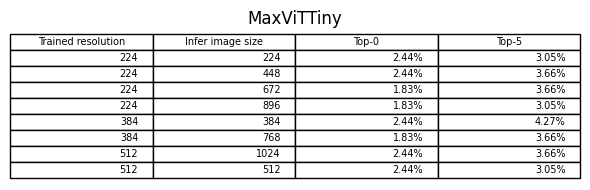

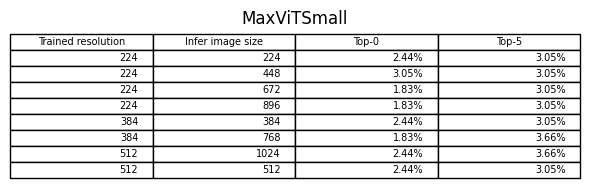

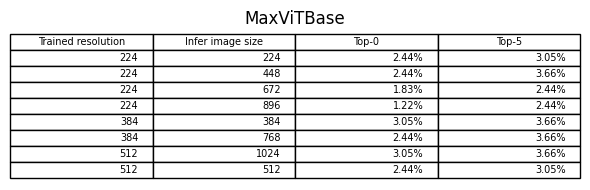

In [32]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt

data = {}
for file in os.listdir('D:\\NN\\OurDreamDiffusion\\code\\maxvit\\results'):
    if file.endswith('.json'):
        file_path = os.path.join('D:\\NN\\OurDreamDiffusion\\code\\maxvit\\results', file)
        file_name = os.path.splitext(file)[0]
        parts = file_name.split('_')
        if parts[0] == 'formatted':
            model = parts[1]
            par1 = parts[2]
            par2 = parts[3]
            key = f"{model}_{par1}_{par2}"
            with open(file_path, 'r') as f:
                content = json.load(f)
            data[key] = {}
            data[key]['top0_perc'] = content['top0_perc']
            data[key]['perc'] = content['perc']

models = ["MaxViTTiny", "MaxViTSmall", "MaxViTBase"]
for amodel in models:
    par1_list =[]
    par2_list =[]
    top_list =[]
    perc_list =[]
    for key, values in data.items():
        splitted = key.split('_')
        model = splitted[0]
        if(model == amodel):
            par1_list.append(splitted[1])
            par2_list.append(splitted[2])
            top_list.append(f"{round(values['top0_perc'], 2)}%")
            perc_list.append(f"{round(values['perc'], 2)}%")
    df = pd.DataFrame({'Trained resolution': par1_list, 'Infer image size': par2_list, 'Top-0': top_list, 'Top-5': perc_list})
    plt.figure(figsize=(6, 2))
    plt.title(amodel)
    plt.table(cellText=df.values, colLabels=df.columns, loc='center')
    plt.axis('off')
    plt.tight_layout()
    plt.show()